In [1]:
from river import tree
from river import metrics, drift
from river import evaluate, naive_bayes, linear_model
from river.datasets import synth, Elec2
from itertools import islice, chain

SEED=42346456

### Agrawal - synthetic

In [2]:
# dataset1, so all models perform the same until stream 4 
stream1 = islice(synth.SEA(variant=2), 1000)
stream2 = islice(synth.SEA(variant=0), 1000)
stream3 = islice(synth.SEA(variant=3), 1000)
stream4 = islice(synth.SEA(variant=2), 1000)
combined_stream = chain(stream1, stream2, stream3, stream4)

# dataset new
gen = synth.Agrawal(classification_function=6, seed=SEED, balance_classes=True)
drift_stream=synth.Agrawal(classification_function=9, seed=SEED, balance_classes=True)
# Take 5000 samples from each stream
stream1 = islice(gen, 4000)
stream2 = islice(drift_stream, 50000)
# Combine them
combined_stream = chain(stream1, stream2)


# Initialize HAT with ADWIN for drift + warning
model_adapt = tree.HoeffdingAdaptiveTreeClassifier(
    grace_period=300,
    delta=1e-5,
    leaf_prediction='nba',
)

model_noadapt = tree.HoeffdingTreeClassifier(
    grace_period=300,
    delta=1e-5,
    leaf_prediction='nb',
)

model_nb = naive_bayes.GaussianNB()

# Metrics to monitor
metric_adapt = metrics.Accuracy()
metric_noadapt = metrics.Accuracy()
metric_nb = metrics.Accuracy()

# Track results
accuracy_adapt, accuracy_noadapt, accuracy_nb=[],[],[]

n = 0
for x, y in combined_stream:
    y_pred_adapt = model_adapt.predict_one(x)
    y_pred_noadapt = model_noadapt.predict_one(x)
    y_pred_nb = model_nb.predict_one(x)
    
    #if not any([y_pred_adapt, y_pred_noadapt, y_pred_nb]):
    # adaptive tree
    metric_adapt.update(y, y_pred_adapt)
    accuracy_adapt.append(metric_adapt.get())

    # noadapt tree
    metric_noadapt.update(y, y_pred_noadapt)
    accuracy_noadapt.append(metric_noadapt.get())

    # NB 
    metric_nb.update(y, y_pred_nb)
    accuracy_nb.append(metric_nb.get())

    for m in [model_adapt, model_noadapt, model_nb]:
        m.learn_one(x, y)
    
    n += 1


assert(all( len(l) == len(accuracy_adapt) for l in [accuracy_adapt, accuracy_noadapt, accuracy_nb]))
print('done')

done


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context('talk')
sns.set_style('darkgrid')

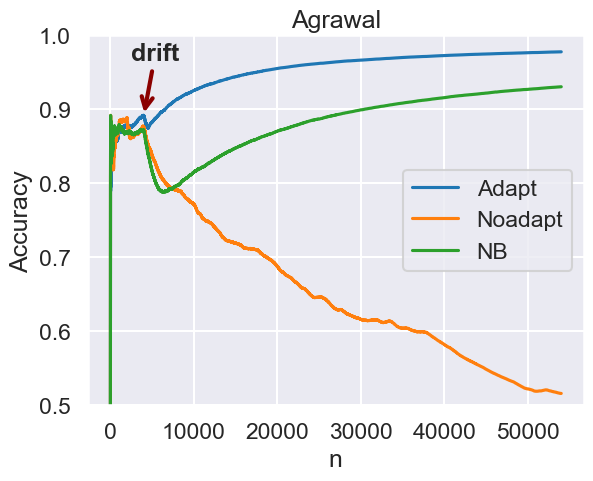

In [4]:
PLOTNAME='Agrawal'
YLAB='Accuracy'
XLAB='n'
YLIM=(0.5, 1)

fig, ax = plt.subplots()

ax.plot(range(n), accuracy_adapt, label='Adapt')
ax.plot(range(n), accuracy_noadapt, label='Noadapt')
ax.plot(range(n), accuracy_nb, label='NB')
ax.annotate("drift", xy=(4000, accuracy_adapt[4000]), xytext=(2500, accuracy_adapt[4000]+0.075), 
                arrowprops=dict(arrowstyle="->",color='darkred',lw=3, mutation_scale=20), weight='bold')

ax.set_ylim(YLIM)
ax.set_title(PLOTNAME)
ax.set_xlabel(XLAB)
ax.set_ylabel(YLAB)
plt.legend()

plt.savefig("agrawal.png", dpi=150, bbox_inches = "tight")

### SEA - synthetic

In [5]:
# dataset1, so all models perform the same until stream 4 
stream1 = islice(synth.SEA(variant=2), 5000)
stream2 = islice(synth.SEA(variant=3), 5000)
stream3 = islice(synth.SEA(variant=2), 5000)
stream4 = islice(synth.SEA(variant=3), 15000)
combined_stream = chain(stream1, stream2, stream3, stream4)

model_adapt = tree.HoeffdingAdaptiveTreeClassifier(
    grace_period=300,
    delta=1e-5,
    leaf_prediction='nba',
)

model_noadapt = tree.HoeffdingTreeClassifier(
    grace_period=300,
    delta=1e-5,
    leaf_prediction='nba',
)

model_nb = naive_bayes.GaussianNB()

adwin = drift.ADWIN(delta=0.0001, clock=10)

# Metrics to monitor
metric_adapt = metrics.Accuracy()
metric_noadapt = metrics.Accuracy()
metric_nb = metrics.Accuracy()

# Track results
accuracy_adapt, accuracy_noadapt, accuracy_nb, drift_detected=[],[],[],[]

n = 0
for x, y in combined_stream:
    y_pred_adapt = model_adapt.predict_one(x)
    y_pred_noadapt = model_noadapt.predict_one(x)
    y_pred_nb = model_nb.predict_one(x)
    
    #if not any([y_pred_adapt, y_pred_noadapt, y_pred_nb]):
    # adaptive tree
    metric_adapt.update(y, y_pred_adapt)
    accuracy_adapt.append(metric_adapt.get())

    # noadapt tree
    metric_noadapt.update(y, y_pred_noadapt)
    accuracy_noadapt.append(metric_noadapt.get())

    # NB 
    metric_nb.update(y, y_pred_nb)
    accuracy_nb.append(metric_nb.get())

    for m in [model_adapt, model_noadapt, model_nb]:
        m.learn_one(x, y)
    
    n += 1

    if n>100:
    # drift detection
        adwin.update(y_pred_adapt)
        if adwin.drift_detected:
            print(f'Change detected n={n}')
            drift_detected.append(n)

assert(all( len(l) == len(accuracy_adapt) for l in [accuracy_adapt, accuracy_noadapt, accuracy_nb]))
print('done')

Change detected n=6240
Change detected n=12740
Change detected n=17720
done


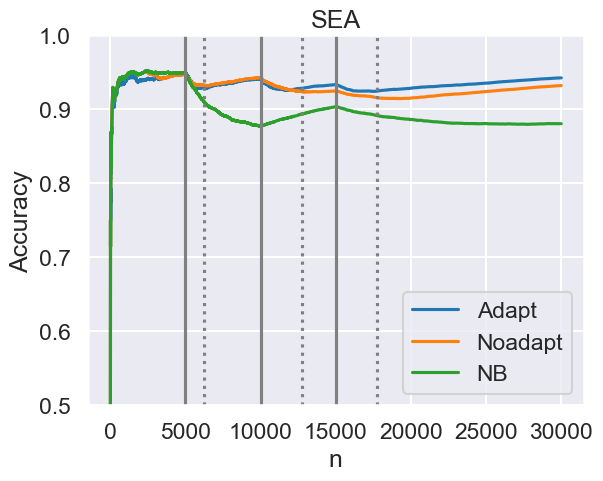

In [6]:
PLOTNAME='SEA'
YLAB='Accuracy'
XLAB='n'
YLIM=(0.5, 1)

fig, ax = plt.subplots()

ax.plot(range(n), accuracy_adapt, label='Adapt')
ax.plot(range(n), accuracy_noadapt, label='Noadapt')
ax.plot(range(n), accuracy_nb, label='NB')

ax.vlines(5000, 0.5, 1, colors='gray') # true drift #1 begin
ax.vlines(10000, 0.5, 1, colors='gray') # true drift #2 begin
ax.vlines(15000, 0.5, 1, colors='gray') # true drift #2 begin
ax.vlines(drift_detected[0], 0.5, 1, colors='gray', linestyles=':') # true drift #1 begin
ax.vlines(drift_detected[1], 0.5, 1, colors='gray', linestyles=':') # true drift #2 begin
ax.vlines(drift_detected[2], 0.5, 1, colors='gray', linestyles=':') # true drift #3 begin


ax.set_ylim(YLIM)
ax.set_title(PLOTNAME)
ax.set_xlabel(XLAB)
ax.set_ylabel(YLAB)
plt.legend()

plt.savefig("sea.png", dpi=150, bbox_inches = "tight")

### Hyperplane - synthetic

In [7]:
gert = synth.Hyperplane(seed=SEED, n_features=3, n_drift_features=3, mag_change=.85, sigma=.15)
dataset = iter(gert.take(10000))

model_adapt = tree.HoeffdingAdaptiveTreeClassifier(
    grace_period=10,
    delta=1e-5,
    leaf_prediction='nb',
)

model_noadapt = tree.HoeffdingTreeClassifier(
    grace_period=10,
    delta=1e-5,
    leaf_prediction='nb',
)

model_nb = naive_bayes.GaussianNB()

# Metrics to monitor
metric_adapt = metrics.Accuracy()
metric_noadapt = metrics.Accuracy()
metric_nb = metrics.Accuracy()

# Track results
accuracy_adapt, accuracy_noadapt, accuracy_nb=[],[],[]

n = 0
for x, y in dataset:
    y_pred_adapt = model_adapt.predict_one(x)
    y_pred_noadapt = model_noadapt.predict_one(x)
    y_pred_nb = model_nb.predict_one(x)
    
    #if not any([y_pred_adapt, y_pred_noadapt, y_pred_nb]):
    # adaptive tree
    metric_adapt.update(y, y_pred_adapt)
    accuracy_adapt.append(metric_adapt.get())

    # noadapt tree
    metric_noadapt.update(y, y_pred_noadapt)
    accuracy_noadapt.append(metric_noadapt.get())

    # NB 
    metric_nb.update(y, y_pred_nb)
    accuracy_nb.append(metric_nb.get())

    for m in [model_adapt, model_noadapt, model_nb]:
        m.learn_one(x, y)
    
    n += 1

assert(all( len(l) == len(accuracy_adapt) for l in [accuracy_adapt, accuracy_noadapt, accuracy_nb]))
print('done')

done


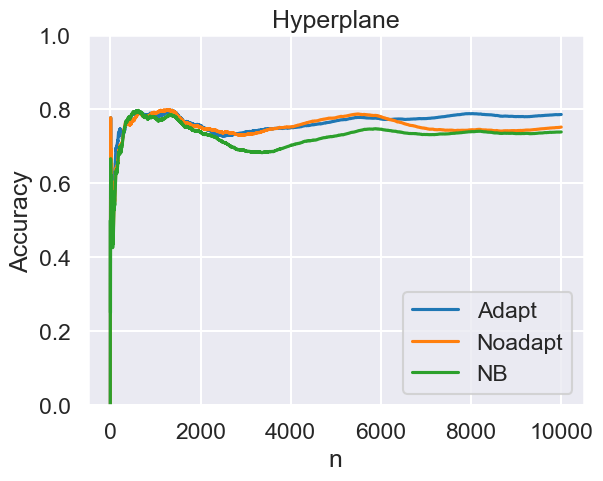

In [8]:
PLOTNAME='Hyperplane'
YLAB='Accuracy'
XLAB='n'
YLIM=(0, 1)

fig, ax = plt.subplots()

ax.plot(range(n), accuracy_adapt, label='Adapt')
ax.plot(range(n), accuracy_noadapt, label='Noadapt')
ax.plot(range(n), accuracy_nb, label='NB')



ax.set_ylim(YLIM)
ax.set_title(PLOTNAME)
ax.set_xlabel(XLAB)
ax.set_ylabel(YLAB)
plt.legend()

plt.savefig("hyperplane.png", dpi=150, bbox_inches = "tight")

### ELEC2 - real

In [9]:
dataset=Elec2()

model_adapt = tree.HoeffdingAdaptiveTreeClassifier(
    grace_period=10,
    delta=1e-5,
    leaf_prediction='nb',
)

model_noadapt = tree.HoeffdingTreeClassifier(
    grace_period=10,
    delta=1e-5,
    leaf_prediction='nb',
)

model_nb = naive_bayes.GaussianNB()

# Metrics to monitor
metric_adapt = metrics.Accuracy()
metric_noadapt = metrics.Accuracy()
metric_nb = metrics.Accuracy()

# Track results
accuracy_adapt, accuracy_noadapt, accuracy_nb=[],[],[]

n = 0
for x, y in dataset:
    y_pred_adapt = model_adapt.predict_one(x)
    y_pred_noadapt = model_noadapt.predict_one(x)
    y_pred_nb = model_nb.predict_one(x)
    
    #if not any([y_pred_adapt, y_pred_noadapt, y_pred_nb]):
    # adaptive tree
    metric_adapt.update(y, y_pred_adapt)
    accuracy_adapt.append(metric_adapt.get())

    # noadapt tree
    metric_noadapt.update(y, y_pred_noadapt)
    accuracy_noadapt.append(metric_noadapt.get())

    # NB 
    metric_nb.update(y, y_pred_nb)
    accuracy_nb.append(metric_nb.get())

    for m in [model_adapt, model_noadapt, model_nb]:
        m.learn_one(x, y)
    
    n += 1

assert(all( len(l) == len(accuracy_adapt) for l in [accuracy_adapt, accuracy_noadapt, accuracy_nb]))
print('done')

done


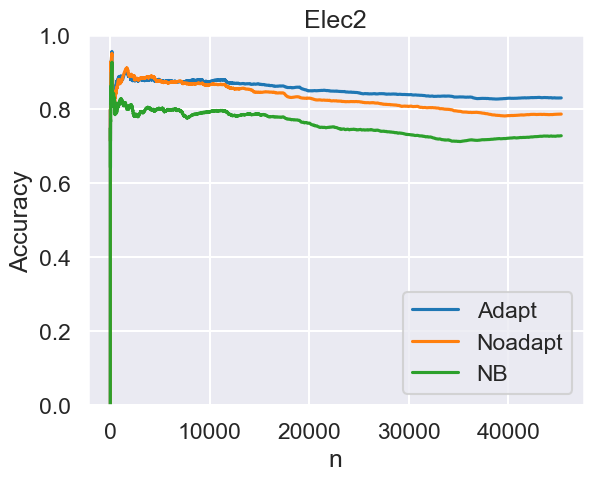

In [10]:
PLOTNAME='Elec2'
YLAB='Accuracy'
XLAB='n'
YLIM=(0, 1)

fig, ax = plt.subplots()

ax.plot(range(n), accuracy_adapt, label='Adapt')
ax.plot(range(n), accuracy_noadapt, label='Noadapt')
ax.plot(range(n), accuracy_nb, label='NB')



ax.set_ylim(YLIM)
ax.set_title(PLOTNAME)
ax.set_xlabel(XLAB)
ax.set_ylabel(YLAB)
plt.legend()

plt.savefig("elec2.png", dpi=150, bbox_inches = "tight")